In [1]:
import shutil
import glob
import matplotlib.pyplot as plt
import json
import math
import cv2
import os
#shutil.rmtree('/kaggle/working/augmented')

In [2]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [3]:
import shutil
import glob
import matplotlib.pyplot as plt
import json
import math
import cv2
import os
#shutil.rmtree('/kaggle/working/augmented')
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import seaborn as sns 
from sklearn.utils import resample

%matplotlib inline

In [4]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

def processing2(img_path):
    img = cv2.imread(img_path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (150,150))
    image = cv2.medianBlur(image, 5)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[:, :, 2] = cv2.equalizeHist(image[:, :, 2])
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    cv2.imwrite(img_path,image)

In [5]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [6]:
os.mkdir('augmented')
os.mkdir('augmented/benign')
os.mkdir('augmented/malignant')

In [7]:
files_benign=getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/benign')

In [8]:
files_malignant=getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/malignant')

In [9]:
benign_images = np.array(Dataset_loader('augmented/benign',150))
malignent_images = np.array(Dataset_loader('augmented/malignant',150))

100%|██████████| 5429/5429 [01:21<00:00, 66.51it/s]


In [10]:
print(benign_images.shape)
print(malignent_images.shape)

(2480, 150, 150, 3)
(5429, 150, 150, 3)


In [11]:
benign_upsampled = resample(benign_images,n_samples=malignent_images.shape[0],random_state=42)
len(benign_upsampled)

5429

In [12]:
whole_data = np.array([])
whole_data

array([], dtype=float64)

In [13]:
whole_data = np.concatenate((benign_upsampled, malignent_images), axis=0)
len(whole_data)

10858

In [14]:
whole_data.shape

(10858, 150, 150, 3)

In [15]:
labels = np.concatenate((np.zeros(len(benign_upsampled)),np.ones(len(malignent_images))))
labels

array([0., 0., 0., ..., 1., 1., 1.])

In [16]:
labels.shape

(10858,)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(whole_data, labels, test_size=0.25,random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size=0.2 , shuffle=True)

In [18]:
X_train.shape

(8143, 150, 150, 3)

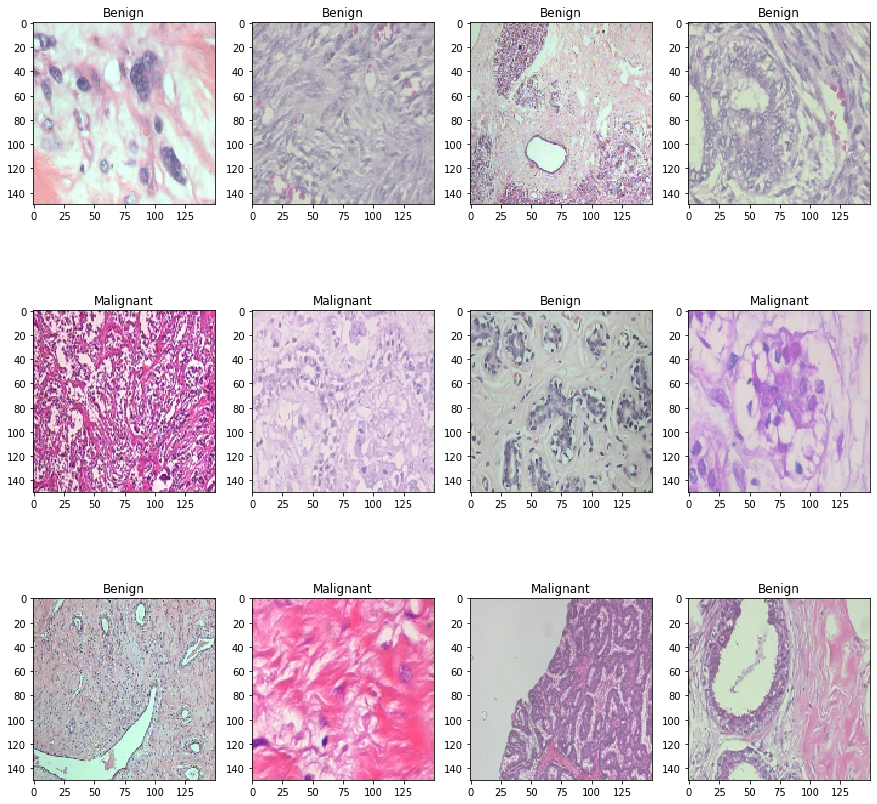

In [19]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3
title = ''
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        title='Benign'
    else:
        title='Malignant'
    ax.title.set_text(title)
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [20]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,  
        vertical_flip=True)

In [21]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, RMSprop

In [23]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

In [24]:
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

In [25]:
_y_test = []
_y_val = []
_y_train = []
for i in y_test:
    _y_test.append(int(i))
for i in y_train:
    _y_train.append(int(i))
for i in y_val:
    _y_val.append(int(i))

In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,MaxPool2D, ZeroPadding2D

In [30]:
def create_model():
    model_net = VGG16(weights=None, include_top=False, input_shape=(150,150, 3))
    

    model = model_net.output
    model = Flatten()(model)
    model = Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001))(model)
    model = Dropout(0.5)(model)
    model = Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001))(model)

    out = Dense(1, activation='sigmoid')(model)  
    model_vgg = Model(inputs=model_net.input,outputs=out)
    
    sgd = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    rms = RMSprop(learning_rate=2e-5)
    
    model_vgg.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['acc',f1_m])
    
    return model_vgg

In [31]:
model = create_model() 

In [32]:
history = model.fit(
    train_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(X_val, y_val))

Epoch 1/15
508/508 [==============================] - 54s 105ms/step - loss: 13.7811 - acc: 0.5812 - f1_m: 0.5373 - val_loss: 11.2886 - val_acc: 0.4862 - val_f1_m: 0.6484
Epoch 2/15
508/508 [==============================] - 53s 104ms/step - loss: 9.0453 - acc: 0.7222 - f1_m: 0.7403 - val_loss: 7.0679 - val_acc: 0.7901 - val_f1_m: 0.8084
Epoch 3/15
508/508 [==============================] - 53s 104ms/step - loss: 5.4895 - acc: 0.7739 - f1_m: 0.7770 - val_loss: 4.0169 - val_acc: 0.8232 - val_f1_m: 0.8229
Epoch 4/15
508/508 [==============================] - 53s 104ms/step - loss: 3.0642 - acc: 0.7819 - f1_m: 0.7870 - val_loss: 2.1537 - val_acc: 0.8158 - val_f1_m: 0.8212
Epoch 5/15
508/508 [==============================] - 53s 105ms/step - loss: 1.7246 - acc: 0.7937 - f1_m: 0.7964 - val_loss: 1.3574 - val_acc: 0.8343 - val_f1_m: 0.8306
Epoch 6/15
508/508 [==============================] - 52s 103ms/step - loss: 1.4380 - acc: 0.7105 - f1_m: 0.7537 - val_loss: 1.3049 - val_acc: 0.8195 - v

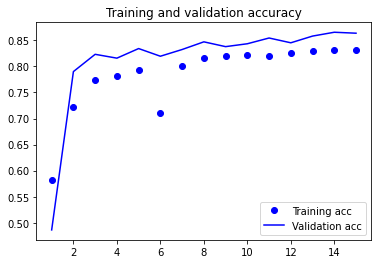

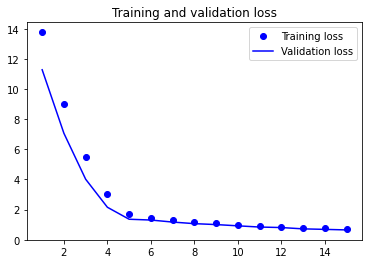

In [33]:
acc = history.history['acc']
 
val_acc = history.history['val_acc'] 
loss = history.history['loss']
val_loss = history.history['val_loss'];  
epochs = range(1, len(acc) + 1) 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best') 

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')

In [34]:
loss, accuracy, f1_score = model.evaluate(X_test, y_test, verbose=0)

2021-11-28 18:25:07.715444: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 146610000 exceeds 10% of free system memory.
2021-11-28 18:25:07.887554: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 146610000 exceeds 10% of free system memory.


In [35]:
print('val_accuracy', accuracy)
print('f1_score', f1_score)

val_accuracy 0.8609576225280762
f1_score 0.8689064979553223
